In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

D:\Anaconda3\envs\deepforest\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 数据增强和预处理
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),          # 随机水平翻转
    transforms.RandomRotation(10),             # 随机旋转 ±10°
    transforms.RandomResizedCrop(224),         # 随机裁剪并调整到 224x224
    transforms.ToTensor(),                     # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 归一化
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),                    # 调整图像大小到 256
    transforms.CenterCrop(224),               # 中心裁剪到 224x224
    transforms.ToTensor(),                    # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 归一化
                         std=[0.229, 0.224, 0.225])
])

In [3]:
from torch.utils.data import random_split, DataLoader

# 读取训练和测试数据
dataset = datasets.ImageFolder(root='data', transform=train_transforms)

train_size = int(0.6 * len(dataset))  
val_size = int(0.2 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [4]:
# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
# 获取类别列表
class_names = dataset.classes

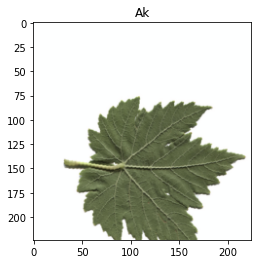

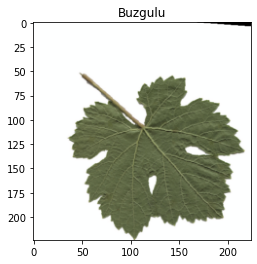

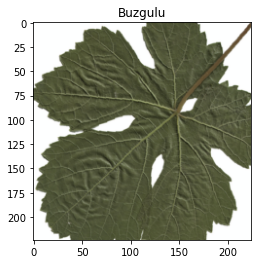

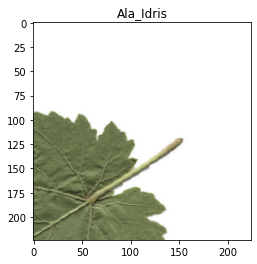

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor, title=None):
    # 将张量转换为图像
    image = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # 去归一化
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

# 获取一个批次的数据
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 可视化
for i in range(4):  # 显示前4张图片
    imshow(images[i], title=class_names[labels[i]])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LightCNN(nn.Module):
    def __init__(self, num_classes):
        super(LightCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 输入: RGB 图像
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # 假设输入图像大小为 224x224
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型
num_classes = len(class_names)
model = LightCNN(num_classes=num_classes)

In [10]:
import torch.optim as optim

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 10.1663, Accuracy: 34.44%
Epoch [2/10], Loss: 2.1635, Accuracy: 37.22%
Epoch [3/10], Loss: 1.1604, Accuracy: 32.22%
Epoch [4/10], Loss: 1.1189, Accuracy: 41.11%
Epoch [5/10], Loss: 1.0591, Accuracy: 53.33%
Epoch [6/10], Loss: 1.0724, Accuracy: 33.89%
Epoch [7/10], Loss: 1.0264, Accuracy: 57.78%
Epoch [8/10], Loss: 0.9993, Accuracy: 55.56%
Epoch [9/10], Loss: 1.0055, Accuracy: 55.00%
Epoch [10/10], Loss: 0.9461, Accuracy: 59.44%


In [11]:
# 验证模型
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Validation Loss: 0.9202, Accuracy: 61.67%


In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 测试模型
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 计算评价指标
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.6167
Precision: 0.6052
Recall: 0.6217
F1 Score: 0.6017


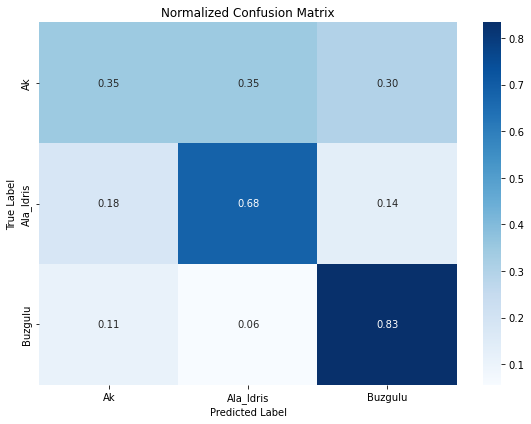

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 设置类别标签
class_labels = class_names

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [14]:
import torch.nn as nn
from torchvision import models

class PretrainedMobileNet(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedMobileNet, self).__init__()
        # 加载预训练的 MobileNet 模型
        self.model = models.mobilenet_v2(pretrained=True)

        # 冻结所有参数
        for param in self.model.parameters():
            param.requires_grad = False

        # 替换 MobileNet 的最后一层分类器
        in_features = self.model.last_channel
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
num_classes = len(class_names)
model = PretrainedMobileNet(num_classes=num_classes)

In [16]:
import torch.optim as optim

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 1.0287, Accuracy: 42.78%
Epoch [2/10], Loss: 0.9017, Accuracy: 56.11%
Epoch [3/10], Loss: 0.7832, Accuracy: 73.33%
Epoch [4/10], Loss: 0.6940, Accuracy: 81.67%
Epoch [5/10], Loss: 0.6381, Accuracy: 78.89%
Epoch [6/10], Loss: 0.5677, Accuracy: 85.56%
Epoch [7/10], Loss: 0.5053, Accuracy: 87.22%
Epoch [8/10], Loss: 0.4808, Accuracy: 83.33%
Epoch [9/10], Loss: 0.4640, Accuracy: 87.22%
Epoch [10/10], Loss: 0.4638, Accuracy: 84.44%


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 测试模型
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 计算评价指标
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9500
Precision: 0.9508
Recall: 0.9530
F1 Score: 0.9507


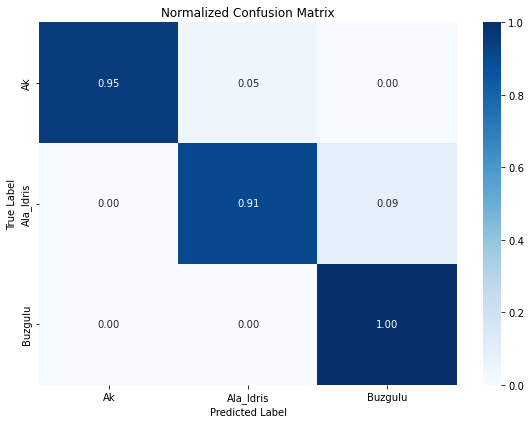

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 设置类别标签
class_labels = class_names

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()